Another common type of machine leanring problem is regression, which consists of predicting a continuous value instead of discrete label. 

# 1. The Boston Housing Price dataset
This project aims to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. This dataset has relatively few data points and each feature in the input data has a different scale. 

In [1]:
# Loading the Boston housing dataset 
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


# 2. Preparing the data 

When feeding the neural network with values that all take wildly different ranges, the network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. The best practice would be to do feature-wise normalization: for each feature in the input data, you substract the mean of the feature and divide by the standard deivation, so that the feature is centered around 0 and has a unit standard deviation.

* The quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

In [2]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -=mean
std = train_data.std(axis=0)
train_data/=std

test_data -=mean
test_data /= std

# 3. Building your network

Since the dataset has so few samples available, a small network should be apploed to mitigate overfitting.

In [3]:
# Model definition
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

Note: since this is a regression model where a scalar output is expected, the network ends with a single unit and no activation. Applying an activation function would constrain the range the output can take. In addition, mean squared error is a widely used loss function for regression problems. 

# 4. Validating your approach using K-fold validation



In [5]:
# K-fold validation

import numpy as np

k=4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #',i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose =0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [6]:
all_scores

[2.1213960352510508,
 2.2713130204984457,
 2.9534898323587853,
 2.3699105706545387]

In [7]:
np.mean(all_scores)

2.4290273646907048

Training the network for a bit longer. Let's keep a record of how well the model does at each epoch by modifying the training loop to save the per epoch validation score log

In [8]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i )
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                       validation_data = (val_data, val_targets),
                       epochs=num_epochs, batch_size = 1, verbose =0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


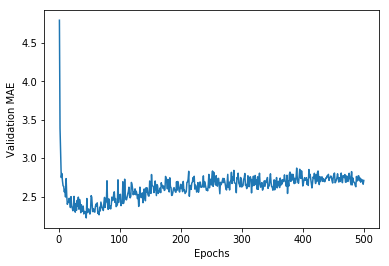

In [11]:
# Plotting the valdiation scores

plt.clf()
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

From the plot, it is difficult to derive meaning due to scaling issues and relatively high variance. This can be solved by omitting the first 10 data points and replacing each point with an exponential moving average of the previous points, to obtain a smooth curve.

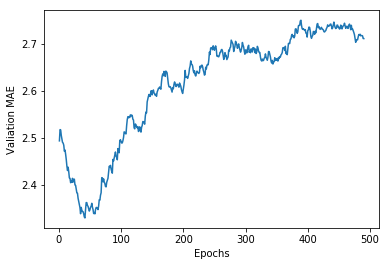

In [12]:
plt.clf()

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Valiation MAE')
plt.show()

From the plot it can be observed that the model starts overfitting after 80 epochs

In [13]:
# Training the final model with num_epochs = 80

model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose =0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

 32/102 [========>.....................] - ETA: 0s

In [14]:
test_mae_score

2.6883581479390464

# Wrapping up

- Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
- Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn't apply for regression. A common regression metric is mean absolute error (MAE).
- When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
- When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
- When little training data is available, it's preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting. 